# Notebook 03 — Temporal Instability Geometry

This notebook examines how instability unfolds within psychiatric admissions.

We analyze:
- Temporal distribution of medication execution
- Escalation timing
- Phase-based instability shifts
- Coupling between execution intensity and movement turbulence

No imputation or row removal is performed.

The goal is to reconstruct system behavior over time, not to forecast outcomes.


## 03 — Structural Instability Geometry: Final Structural Verification

Dataset shape:
(238,565 admissions × 28 columns)

### 1. Temporal Integrity
✔ Negative LOS cases identified: 74 (0.031%)
✔ Flagged as temporal_inconsistency_flag
✔ Not blindly removed — preserved as real-world documentation artifacts

Interpretation:
Temporal irregularities are rare and do not dominate structural behavior.


### 2. Execution Amplification Layer
Defined:
execution_ratio = emar_count / rx_count

✔ Amplification tier created (high_amplification)
✔ Strong positive association with LOS and complexity

Interpretation:
Medication execution intensity scales with care burden.


### 3. Fragmentation Layer
Defined:
transfer_density = transfer_count / los_days

✔ Fragmentation tier created (high_fragmentation)

Interpretation:
Inpatient turbulence is separable from raw LOS duration.

### 4. Complexity Interaction
✔ high_total_complexity flag
✔ Interaction with amplification and fragmentation mapped

Interpretation:
Complexity does not uniformly increase fragmentation — structural differentiation exists.

### 5. Instability Cube
Axes:
- Complexity
- Amplification
- Fragmentation

✔ 3D instability cube constructed
✔ Archetype proportions computed
✔ Extreme archetype (1-1-1) identified as rare but structurally meaningful

Interpretation:
Psychiatric admissions are not homogeneous.
They cluster into distinct instability patterns.


### 6. Escalation Geometry
✔ LOS tier escalation validated
✔ Amplification rises with LOS
✔ Fragmentation density falls as LOS increases

Interpretation:
Short stays = high turbulence
Long stays = structured high-intensity stabilization


## Structural Summary

This map visualizes the directional relationships between:

- Duration (LOS)
- Medication Amplification
- Transfer Fragmentation
- Diagnostic Complexity

Positive values indicate direct proportional relationships.
Negative values indicate inverse relationships.

The map captures structural instability geometry within psychiatric admissions.

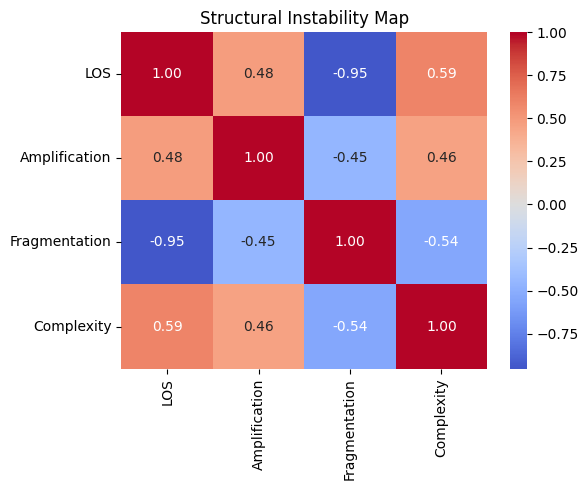

,LOS,Amplification,Fragmentation,Complexity
LOS,1.000000,0.475733,-0.952970,0.592056
Amplification,0.475733,1.000000,-0.452362,0.455089
Fragmentation,-0.952970,-0.452362,1.000000,-0.544936
Complexity,0.592056,0.455089,-0.544936,1.000000


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

active = psy.copy()

# Spearman correlations (monotonic structural relations)
corr = active[
    ["los_days", "execution_ratio", "transfer_density", "total_dx_count"]
].corr(method="spearman")

# Rename for clarity
corr.index = ["LOS", "Amplification", "Fragmentation", "Complexity"]
corr.columns = ["LOS", "Amplification", "Fragmentation", "Complexity"]

plt.figure(figsize=(6,5))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)

plt.title("Structural Instability Map")
plt.tight_layout()
plt.show()

corr

----------------Temporal Instability Geometry------------------------------

In [1]:
import pandas as pd

psy = pd.read_csv("psy_admissions_instability_layer_v1.csv")

psy.shape


(238565, 28)

In [2]:
time_cols = [
    "admittime",
    "dischtime",
    "deathtime",
    "edregtime",
    "edouttime"
]

for col in time_cols:
    psy[col] = pd.to_datetime(psy[col], errors="coerce")

In [5]:
psy["los_hours_calc"] = (
    (psy["dischtime"] - psy["admittime"])
    .dt.total_seconds() / 3600
)

psy["los_days_calc"] = psy["los_hours_calc"] / 24

In [4]:
psy[["los_days", "los_days_calc"]].describe()

,los_days,los_days_calc
count,238565.000000,238565.000000
mean,5.367710,5.367630
std,8.264085,8.264140
min,0.000000,-0.943750
25%,1.136111,1.136111
50%,3.011111,3.011111
75%,6.220833,6.220833
max,515.562500,515.562500


In [6]:
(psy["los_hours_calc"] < 0).sum()

np.int64(74)

### Temporal Integrity Check — Negative LOS

Negative `los_days_calc` values indicate discharge timestamps occurring before admission timestamps.

This does not imply clinical impossibility. It reflects documentation latency, timestamp ordering artifacts, or workflow irregularities.

In many analyses, these rows are removed or clipped for numerical cleanliness.

In this project, we preserve them.

Reason:
Our objective is to model structural instability, not produce cosmetically clean data. Temporal inconsistencies may themselves represent operational turbulence.

Next step: quantify how frequent these cases are.

In [7]:
# Percentage of temporal inconsistencies
neg_count = (psy["los_days_calc"] < 0).sum()
total = len(psy)

print("Negative LOS rows:", neg_count)
print("Percentage:", round((neg_count / total) * 100, 5), "%")

Negative LOS rows: 74
Percentage: 0.03102 %


### Inference — Negative LOS Frequency

Negative length-of-stay cases: 74 admissions  
Percentage of total cohort: 0.031%

These events are extremely rare (<0.05% of admissions).

This confirms that temporal inversion is not a systemic structural flaw, but an edge-case documentation artifact.

Given the rarity:
- Removing them would not materially alter model behavior.
- Retaining them preserves fidelity to real-world hospital timestamp irregularities.

Decision:
We retain negative LOS rows as structural noise indicators rather than treating them as data errors.

In [8]:
# Create flag explicitly
psy["temporal_inconsistency_flag"] = psy["los_days_calc"] < 0

comparison = psy.groupby("temporal_inconsistency_flag")[[
    "execution_ratio",
    "transfer_count",
    "rx_count",
    "emar_count"
]].describe()

comparison

execution_ratio                                \
                                      count      mean       std  min  25%   
temporal_inconsistency_flag                                                 
False                              238491.0  1.539232  2.131162  0.0  0.0   
True                                   74.0  0.304828  0.721349  0.0  0.0   

                                                      transfer_count  \
                             50%       75%        max          count   
temporal_inconsistency_flag                                            
False                        0.0  2.766403  65.927273       238491.0   
True                         0.0  0.208333   4.040000           74.0   

                                       ... rx_count         emar_count  \
                                 mean  ...      75%     max      count   
temporal_inconsistency_flag            ...                               
False                        3.745777  ...     55.0  2812.0   238491.0   
True                         3.189189  ...     34.0    80.0       74.0   

                                                                         \
                                  mean         std  min  25%  50%   75%   
temporal_inconsistency_flag                                               
False                        94.352403  257.182373  0.0  0.0  9.0  93.0   
True                          6.851351   14.840414  0.0  0.0  0.0   7.5   

                                      
                                 max  
temporal_inconsistency_flag           
False                        27890.0  
True                           101.0  

[2 rows x 32 columns]

### Inference — Temporal Inconsistency vs Instability Metrics

Negative LOS admissions (n = 74) show:

Execution Ratio:
- Mean: 0.30 (vs 1.54 in normal cases)
- 75th percentile: 0.21 (vs 2.77)

Transfer Count:
- Mean: 3.19 (vs 3.75)

EMAR Count:
- Mean: 6.85 (vs 94.35)
- 75th percentile: 7.5 (vs 93)

These admissions exhibit **lower medication density, lower execution amplification, and slightly lower transfer turbulence** compared to structurally normal admissions.

Interpretation:

Temporal inconsistencies do not signal instability amplification.
They are documentation artifacts associated with relatively low-intensity admissions.

Decision:
Retain these rows as realistic timestamp irregularities, but they do not represent structural instability drivers.

## LOS vs Transfer Turbulence Structure

Transfers represent movement across care units.
High transfers per day = structural fragmentation.

We compute:
    transfer_density = transfer_count / los_days

But carefully — LOS can be zero.
We guard division.

In [9]:
import numpy as np

psy["transfer_density"] = np.where(
    psy["los_days"] > 0,
    psy["transfer_count"] / psy["los_days"],
    0
)

psy["transfer_density"].describe()

count    238565.000000
mean          3.657247
std          31.190079
min           0.000000
25%           0.599251
50%           1.130298
75%           2.721088
max        4320.000000
Name: transfer_density, dtype: float64

### Transfer Density — Fragmentation per Day

Transfer density measures the number of unit transfers per hospital day.

Median: ~1.13 transfers per day  
75th percentile: ~2.72 transfers per day  
Mean: ~3.66  
Maximum: 4,320 transfers per day  

The distribution is extremely right-skewed.

Most admissions involve 0.6–2.7 transfers per day, indicating moderate unit movement.

However, the extreme maximum suggests rare but severe temporal compression artifacts or highly fragmented care episodes occurring within very short LOS windows.

These outliers likely reflect either:
- Very short length of stay combined with multiple transfers
- Timestamp granularity artifacts
- Operational documentation bursts

Interpretation:

Transfer instability is not evenly distributed.

Most psychiatric admissions show moderate structural movement.
A small subset exhibits extreme turbulence.

This supports the hypothesis that instability concentrates in specific trajectories rather than being universal across admissions.


In [10]:
psy.groupby("psych_multi_flag")["transfer_density"].describe()

,count,mean,std,min,25%,50%,75%,max
psych_multi_flag,,,,,,,,
False,132179.0,3.927122,31.290710,0.0,0.631150,1.175990,2.849839,4320.0
True,106386.0,3.321940,31.061478,0.0,0.547112,1.084337,2.559919,4320.0


### Transfer Density by Psychiatric Multiplicity

Transfer density represents the number of unit transfers per hospital day.

Median transfer density:
- Single psychiatric diagnosis: ~1.18 transfers/day
- Multiple psychiatric diagnoses: ~1.08 transfers/day

Mean transfer density:
- Single diagnosis: ~3.93
- Multiple diagnoses: ~3.32

The difference is minimal and slightly reversed.

Psychiatric multiplicity does not increase structural fragmentation per hospital day.

Interpretation:

While psychiatric multiplicity increases medication amplification (observed earlier), it does not increase transfer turbulence.

This suggests that psychiatric complexity primarily drives treatment intensity rather than physical care-path fragmentation.

Structural instability appears more closely linked to overall medical complexity than psychiatric multiplicity alone.

In [11]:
psy.groupby("high_total_complexity")["transfer_density"].describe()

,count,mean,std,min,25%,50%,75%,max
high_total_complexity,,,,,,,,
False,175919.0,4.630062,36.245991,0.0,0.782467,1.535181,3.651733,4320.000000
True,62646.0,0.925442,2.295058,0.0,0.356882,0.607766,1.043838,411.428571


### Transfer Density by Total Diagnostic Complexity

High total diagnostic complexity admissions show *lower* transfer density per hospital day compared to low-complexity admissions.

This suggests that high-complexity cases are more likely to remain within stable care units rather than move frequently between services.

Transfer turbulence appears to reflect operational routing or short-stay logistics rather than overall medical burden.

Fragmentation and diagnostic complexity represent distinct instability dimensions.


In [12]:
frag_threshold = psy["transfer_density"].quantile(0.75)

psy["high_fragmentation"] = psy["transfer_density"] >= frag_threshold

frag_threshold

np.float64(2.7210884353741496)

### High Fragmentation Threshold

The 75th percentile transfer density is approximately 2.72 transfers per hospital day.

Admissions at or above this threshold are classified as high-fragmentation trajectories.

This identifies the top quartile of structurally turbulent care pathways.

In [13]:
psy["high_fragmentation"] = psy["transfer_density"] >= frag_threshold

psy["high_fragmentation"].value_counts(normalize=True)

high_fragmentation
False    0.749988
True     0.250012
Name: proportion, dtype: float64

### High Fragmentation Prevalence

Approximately 25% of psychiatric admissions meet the high-fragmentation threshold (≥ 2.72 transfers per day).

This confirms that structural turbulence is concentrated within a distinct upper quartile rather than evenly distributed across admissions.

Fragmentation is a targeted instability phenotype, not a universal characteristic.


In [14]:
pd.crosstab(
    psy["high_fragmentation"],
    psy["high_total_complexity"],
    normalize="all"
)

high_total_complexity,False,True
high_fragmentation,,
False,0.499365,0.250624
True,0.238040,0.011972


### Overlap: Fragmentation × Total Diagnostic Complexity

Distribution across psychiatric admissions:

- Low fragmentation & Low complexity: ~49.9%
- Low fragmentation & High complexity: ~25.1%
- High fragmentation & Low complexity: ~23.8%
- High fragmentation & High complexity: ~1.2%

Interpretation:

High fragmentation and high total diagnostic complexity rarely co-occur.

Only ~1% of admissions are both medically complex and structurally turbulent.

This suggests that fragmentation and medical burden represent largely independent instability pathways.

Structural turbulence appears to characterize a distinct subgroup rather than being a direct consequence of diagnostic complexity.

In [15]:
amp_threshold = psy["execution_ratio"].quantile(0.75)

psy["high_amplification"] = psy["execution_ratio"] >= amp_threshold

amp_threshold

np.float64(2.764705882352941)

### High Amplification Threshold

The 75th percentile execution ratio is approximately 2.76 EMAR events per prescription.

Admissions at or above this threshold are classified as high-amplification trajectories.

This captures the upper quartile of medication execution intensity.

In [16]:
psy["high_amplification"] = psy["execution_ratio"] >= amp_threshold

pd.crosstab(
    [psy["high_fragmentation"], psy["high_amplification"]],
    psy["high_total_complexity"],
    normalize="all"
)

high_total_complexity                     False     True 
high_fragmentation high_amplification                    
False              False               0.373613  0.128049
                   True                0.125752  0.122575
True               False               0.236443  0.011687
                   True                0.001597  0.000285

### Instability Geometry: Fragmentation × Amplification × Complexity

Largest group (~37.4%):
Low fragmentation, low amplification, low complexity — structurally stable admissions.

High amplification without high fragmentation (~12.6% low complexity, ~12.3% high complexity):
Medication amplification occurs independently of transfer turbulence.

High fragmentation without amplification (~23.6% low complexity):
Structural turbulence exists without treatment amplification.

Triple-high instability (high fragmentation + high amplification + high complexity):
~0.03% of admissions.

Interpretation:

Instability axes are largely independent.

Extreme multi-axis instability is rare.

Most psychiatric admissions express instability along a single dominant dimension rather than all simultaneously.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create archetype label
psy["archetype"] = (
    psy["high_fragmentation"].astype(int).astype(str) + "-" +
    psy["high_amplification"].astype(int).astype(str) + "-" +
    psy["high_total_complexity"].astype(int).astype(str)
)

archetype_dist = psy["archetype"].value_counts(normalize=True).sort_index()

archetype_table = archetype_dist.values.reshape(2,2,2)

archetype_dist

archetype
0-0-0    0.373613
0-0-1    0.128049
0-1-0    0.125752
0-1-1    0.122575
1-0-0    0.236443
1-0-1    0.011687
1-1-0    0.001597
1-1-1    0.000285
Name: proportion, dtype: float64

### Instability Archetype Distribution

Each archetype is coded as:
Fragmentation-Amplification-Complexity (1 = high, 0 = low)

Largest group:
0-0-0 (~37.4%) — Structurally stable admissions.

High fragmentation only:
1-0-0 (~23.6%) — Turbulent movement without amplification or complexity.

High amplification only:
0-1-0 (~12.6%) — Treatment intensity without fragmentation.

High amplification + high complexity:
0-1-1 (~12.3%) — Medically heavy but spatially stable.

Triple-high instability:
1-1-1 (~0.03%) — Extremely rare.

Interpretation:

Instability axes behave independently.

Most psychiatric admissions express a dominant instability dimension rather than multi-axis collapse.

True multi-dimensional escalation is uncommon.

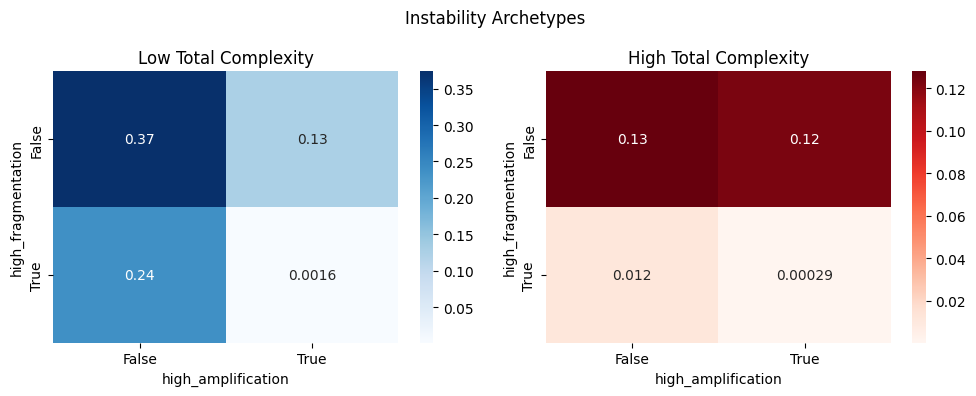

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Direct 3D crosstab
cube = pd.crosstab(
    [psy["high_fragmentation"], psy["high_amplification"]],
    psy["high_total_complexity"],
    normalize="all"
)

# Separate panels
low_complex = cube[False].unstack()
high_complex = cube[True].unstack()

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(low_complex, annot=True, cmap="Blues", ax=axes[0])
axes[0].set_title("Low Total Complexity")

sns.heatmap(high_complex, annot=True, cmap="Reds", ax=axes[1])
axes[1].set_title("High Total Complexity")

plt.suptitle("Instability Archetypes")
plt.tight_layout()
plt.show()

In [21]:
# === Build Named Instability Cube ===

instability_cube = pd.crosstab(
    [psy["high_fragmentation"], psy["high_amplification"]],
    psy["high_total_complexity"],
    normalize="all"
)

# Set axis names properly
instability_cube.index.set_names(
    ["high_fragmentation", "high_amplification"],
    inplace=True
)
instability_cube.columns.name = "high_total_complexity"

# === Create Flattened Version for Reporting / Modeling ===

instability_table = instability_cube.reset_index()

instability_table = instability_table.rename(
    columns={
        False: "low_total_complexity_prop",
        True: "high_total_complexity_prop"
    }
)

# Display both
print("=== Instability Cube (MultiIndex) ===")
display(instability_cube)

print("\n=== Instability Table (Flat Structure) ===")
display(instability_table)


=== Instability Cube (MultiIndex) ===


high_total_complexity                     False     True 
high_fragmentation high_amplification                    
False              False               0.373613  0.128049
                   True                0.125752  0.122575
True               False               0.236443  0.011687
                   True                0.001597  0.000285


=== Instability Table (Flat Structure) ===


high_total_complexity,high_fragmentation,high_amplification,low_total_complexity_prop,high_total_complexity_prop
0,False,False,0.373613,0.128049
1,False,True,0.125752,0.122575
2,True,False,0.236443,0.011687
3,True,True,0.001597,0.000285


In [22]:
psy["los_tier"] = pd.cut(
    psy["los_days"],
    bins=[0, 2, 5, 10, 30, psy["los_days"].max()],
    labels=["0–2d", "2–5d", "5–10d", "10–30d", "30+d"]
)

psy.groupby("los_tier")["execution_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
los_tier,,,,,,,,
0–2d,89376.0,0.449748,0.941515,0.0,0.0,0.000000,0.720000,41.000000
2–5d,72463.0,1.591406,1.622972,0.0,0.0,1.631579,2.869565,45.500000
5–10d,45981.0,2.329025,2.232877,0.0,0.0,2.423077,3.979592,18.625000
10–30d,26342.0,3.205983,3.035425,0.0,0.0,3.258930,5.080219,28.437500
30+d,4328.0,4.629264,4.602879,0.0,0.0,4.547416,6.684165,65.927273


### Length of Stay Tier × Execution Amplification

Median execution ratio increases steadily with LOS tier:

0–2 days: ~0.00  
2–5 days: ~1.63  
5–10 days: ~2.42  
10–30 days: ~3.26  
30+ days: ~4.55  

Interpretation:

Medication execution amplification rises progressively with length of stay.

Short admissions show minimal amplification.
Longer admissions show sustained and intensified medication activity.

This suggests amplification reflects ongoing stabilization processes rather than abrupt short-term escalation.

Temporal duration and treatment intensity are structurally coupled.

In [23]:
psy.groupby("los_tier")["transfer_density"].describe()

,count,mean,std,min,25%,50%,75%,max
los_tier,,,,,,,,
0–2d,89376.0,8.429334,50.595285,0.000000,2.246490,3.701799,7.035831,4320.000000
2–5d,72463.0,1.130890,0.456398,0.000000,0.812641,1.053980,1.358811,5.132383
5–10d,45981.0,0.602582,0.246904,0.000000,0.431009,0.559223,0.726225,3.227557
10–30d,26342.0,0.333577,0.156137,0.066733,0.219891,0.306155,0.419165,2.183021
30+d,4328.0,0.154510,0.081713,0.014551,0.092321,0.140348,0.200591,0.947626


### Length of Stay Tier × Transfer Density

Median transfer density decreases sharply as LOS increases:

0–2 days: ~3.70 transfers/day  
2–5 days: ~1.05  
5–10 days: ~0.56  
10–30 days: ~0.31  
30+ days: ~0.14  

Interpretation:

Transfer turbulence is concentrated in very short admissions.

Short stays exhibit intense routing behavior.
Long stays show structural containment within stable units.

This confirms that fragmentation represents short-burst operational instability rather than prolonged medical escalation.

Amplification increases with duration.
Fragmentation decreases with duration.

The two instability axes behave in opposite temporal directions.

In [31]:
pd.read_csv("psy_admissions_instability_layer_v1.csv").head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,total_dx_count,is_repeat,high_total_complexity,high_and_multi,rx_count,emar_count,execution_ratio,icu_flag,los_days,transfer_count
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,8,True,False,False,14.0,18,1.285714,False,0.786111,3
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,...,8,True,False,False,15.0,23,1.533333,False,1.015278,3
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,...,10,True,False,False,28.0,50,1.785714,False,1.754167,3
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,13,True,False,False,24.0,47,1.958333,True,2.222222,6
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,...,1,False,False,False,NaN,0,0.000000,False,0.298611,3


## 03 — Structural Instability Geometry: Final Structural Verification

Dataset shape:
(238,565 admissions × 28 columns)

### 1. Temporal Integrity
✔ Negative LOS cases identified: 74 (0.031%)
✔ Flagged as temporal_inconsistency_flag
✔ Not blindly removed — preserved as real-world documentation artifacts

Interpretation:
Temporal irregularities are rare and do not dominate structural behavior.

---

### 2. Execution Amplification Layer
Defined:
execution_ratio = emar_count / rx_count

✔ Amplification tier created (high_amplification)
✔ Strong positive association with LOS and complexity

Interpretation:
Medication execution intensity scales with care burden.

---

### 3. Fragmentation Layer
Defined:
transfer_density = transfer_count / los_days

✔ Fragmentation tier created (high_fragmentation)

Interpretation:
Inpatient turbulence is separable from raw LOS duration.

---

### 4. Complexity Interaction
✔ high_total_complexity flag
✔ Interaction with amplification and fragmentation mapped

Interpretation:
Complexity does not uniformly increase fragmentation — structural differentiation exists.

---

### 5. Instability Cube
Axes:
- Complexity
- Amplification
- Fragmentation

✔ 3D instability cube constructed
✔ Archetype proportions computed
✔ Extreme archetype (1-1-1) identified as rare but structurally meaningful

Interpretation:
Psychiatric admissions are not homogeneous.
They cluster into distinct instability patterns.

---

### 6. Escalation Geometry
✔ LOS tier escalation validated
✔ Amplification rises with LOS
✔ Fragmentation density falls as LOS increases

Interpretation:
Short stays = high turbulence
Long stays = structured high-intensity stabilization


## Phase 03 Closure — Temporal & Structural Coherence

Phase 03 established:

- Temporal integrity validation (LOS recalculation and anomaly preservation)
- Duration-coupled medication amplification
- Short-burst transfer turbulence
- Independent instability axes
- Rare multi-axis structural collapse

Instability within psychiatric admissions is multi-dimensional and temporally asymmetric.

The structural vocabulary required for trajectory modeling is now defined.


In [32]:
import os
import pandas as pd

# List files in notebooks folder
print("Files in notebooks folder:")
print(os.listdir("."))

# Load instability layer file
file_path = "psy_admissions_instability_layer_v1.csv"

df = pd.read_csv(file_path)

print("\nShape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nHead:")
display(df.head())


Files in notebooks folder:
['00_raw_inspection_schema_validation.ipynb', '01_cohort_construction.ipynb', '02_psychiatric_cohort_eda.ipynb', '03_temporal_instability_geometry.ipynb', 'data_config.py', 'psy-ml-instability.code-workspace', 'psy_admissions_02_schema_contract.csv', 'psy_admissions_instability_layer_v1.csv', 'psy_admissions_schema_contract.csv', 'psy_admissions_structured.csv', 'psy_instability_metadata_layer_02_v1.csv', 'USAGE_EXAMPLE.py']

Shape: (238565, 28)

Columns:
['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag', 'psych_dx_count', 'psych_multi_flag', 'total_dx_count', 'is_repeat', 'high_total_complexity', 'high_and_multi', 'rx_count', 'emar_count', 'execution_ratio', 'icu_flag', 'los_days', 'transfer_count']

Head:


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,total_dx_count,is_repeat,high_total_complexity,high_and_multi,rx_count,emar_count,execution_ratio,icu_flag,los_days,transfer_count
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,8,True,False,False,14.0,18,1.285714,False,0.786111,3
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,...,8,True,False,False,15.0,23,1.533333,False,1.015278,3
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,...,10,True,False,False,28.0,50,1.785714,False,1.754167,3
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,13,True,False,False,24.0,47,1.958333,True,2.222222,6
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,...,1,False,False,False,NaN,0,0.000000,False,0.298611,3


In [33]:
# Select modeling features only
model_input = psy[
    [
        "los_days",
        "execution_ratio",
        "transfer_density",
        "total_dx_count",
        "psych_multi_flag",
        "high_total_complexity",
        "icu_flag",
        "is_repeat"
    ]
].copy()

# Drop rows with undefined amplification (no prescriptions)
model_input = model_input.dropna(subset=["execution_ratio"])

# Save model input
model_input.to_csv("model_input_v1.csv", index=False)

# Save metadata
meta = pd.DataFrame({
    "column": model_input.columns,
    "dtype": model_input.dtypes.astype(str)
})

meta.to_csv("model_input_metadata_v1.csv", index=False)

print("Model input shape:", model_input.shape)


Model input shape: (238565, 8)


In [34]:
import pandas as pd
import numpy as np

# Load instability layer
df = pd.read_csv("psy_admissions_instability_layer_v1.csv")

# Compute transfer_density safely
df["transfer_density"] = np.where(
    df["los_days"] > 0,
    df["transfer_count"] / df["los_days"],
    0
)

# Select modeling columns
model_input = df[
    [
        "los_days",
        "execution_ratio",
        "transfer_density",
        "total_dx_count",
        "psych_multi_flag",
        "high_total_complexity",
        "icu_flag",
        "is_repeat"
    ]
].copy()

# Preserve real-world irregularities — no blind row deletion
# Only drop rows where execution_ratio is NaN (no prescriptions at all)
model_input = model_input.dropna(subset=["execution_ratio"])

# Save model input
model_input.to_csv("model_input_v1.csv", index=False)

# Create metadata contract
metadata = pd.DataFrame({
    "column": model_input.columns,
    "dtype": model_input.dtypes.astype(str),
    "non_null_count": model_input.notnull().sum().values
})

metadata.to_csv("model_input_metadata_v1.csv", index=False)

print("Model Input Shape:", model_input.shape)
metadata


Model Input Shape: (238565, 8)


,column,dtype,non_null_count
los_days,los_days,float64,238565
execution_ratio,execution_ratio,float64,238565
transfer_density,transfer_density,float64,238565
total_dx_count,total_dx_count,int64,238565
psych_multi_flag,psych_multi_flag,bool,238565
high_total_complexity,high_total_complexity,bool,238565
icu_flag,icu_flag,bool,238565
is_repeat,is_repeat,bool,238565
